In [1]:
import os

from IPython.display import clear_output

import numpy as np
import tensorflow as tf

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
#os.environ['MUJOCO_GL'] = "egl"
os.environ['MUJOCO_GL'] = "glfw" #for mac
try:
  import mujoco
except Exception as e:
  raise e from RuntimeError("Something went wrong during import")
# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

2024-03-01 10:26:29.945417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


""

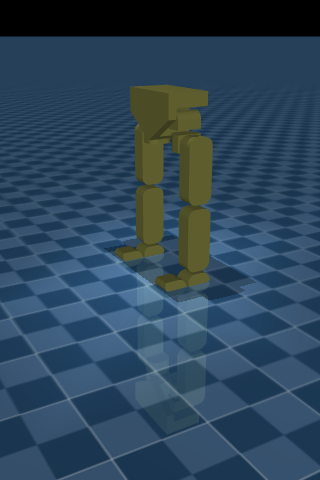

In [178]:
model = mujoco.MjModel.from_xml_path('bipede.xml')
data = mujoco.MjData(model)

ctx = mujoco.GLContext(1000, 1000)
ctx.make_current()

renderer = mujoco.Renderer(model, 480,)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [413]:
def motor_control(data, ref_pos, integral):
    cmd = np.zeros(12)
    state = 180*data.qpos[7:]/np.pi
    vel = data.qvel[6:]
    integral = np.clip(integral + 180*data.qpos[7:]/np.pi, -50, 50)
    
    cmd = -10*(state-ref_pos) - 2*vel #- 0.01*integral
    return cmd, integral


def plot(model, data, duration = 2, fps = 25):
    clear_output(wait=True)
    Cmd =[]
    Pos = []
    # Simulate and display video.
    frames = []
    mujoco.mj_resetData(model, data)  # Reset state and time.
    mujoco.mj_forward(model, data)
    integral = np.zeros(12)
    ref_pos = 30*np.ones(12)
    while data.time < duration:
      data.ctrl, integral = motor_control(data, ref_pos, integral)
      Cmd.append(data.ctrl[-5])
      Pos.append(180*data.qpos[-5]/np.pi)
      mujoco.mj_step(model, data)
      if len(frames) < data.time * fps:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
    media.show_video(frames, fps= fps)
    plt.plot(Cmd)
    plt.plot(Pos)
    plt.legend(["Cmd", "Pos"])
    plt.show()

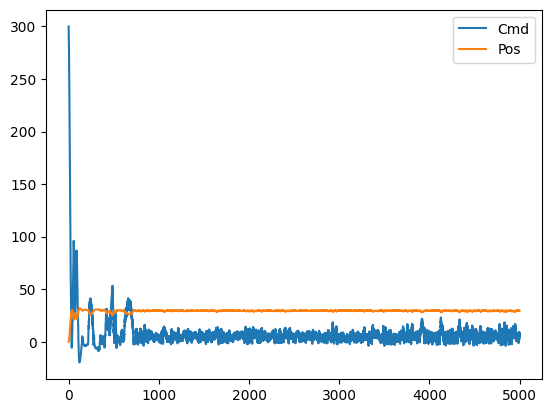

In [414]:
plot(model, data, duration = 10, fps = 25)